In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
%matplotlib inline


In [3]:
file_name = 'crypto_data_2.csv'
df = pd.read_csv(file_name)
print(len(df))

#df['date'] = pd.to_datetime(df['date'])



df.index = range(len(df))


df.dropna(inplace=True)
df.reset_index(drop=True)

df.isnull().values.any()


22545


False

In [4]:

df['SMA_14'] = df['close'].rolling(14).mean().shift()
df['SMA_30'] = df['close'].rolling(20).mean().shift()
df['SMA_50'] = df['close'].rolling(50).mean().shift()
df['SMA_200'] = df['close'].rolling(200).mean().shift()



def relative_strength_idx(df, n=14):
    close = df['close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI_14'] = relative_strength_idx(df, 14).fillna(0)
df['RSI_30'] = relative_strength_idx(df, 30).fillna(0)
df['RSI_50'] = relative_strength_idx(df, 50).fillna(0)
df['RSI_200'] = relative_strength_idx(df, 200).fillna(0)

df.dropna(inplace=True)
df.isnull().values.any()



False

In [5]:
test_size  = 0.15
valid_size = 0.15


test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()



In [6]:
drop_cols = ['date', 'volume', 'open', 'low', 'high', 'adjclose', 'formatted_date', 'coin']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

test_df['close'].values

test_df.head()

,close,SMA_14,SMA_30,SMA_50,SMA_200,RSI_14,RSI_30,RSI_50,RSI_200
5366,0.967830,1.003164,1.004300,1.002446,0.998736,49.953183,49.500356,49.077884,49.617450
5367,0.969273,1.003127,1.004371,1.001773,0.998420,50.898173,48.318219,48.710551,49.933870
5368,1.016235,1.003819,1.007022,1.000838,0.998366,47.306573,50.197792,51.377853,50.025363
5369,0.969162,1.001887,1.003822,1.001835,0.998387,47.415847,49.392930,49.577168,49.915929
5370,1.010253,1.000037,0.996762,1.001525,0.998318,52.181336,50.894251,49.128424,50.261669


In [7]:
y_train = train_df['close'].copy().values
X_train = train_df.drop(['close'], 1).values

y_valid = valid_df['close'].copy().values
X_valid = valid_df.drop(['close'], 1).values

print(test_df['close'])
y_test  = test_df['close'].copy().values
X_test  = test_df.drop(['close'], 1).values

5366    0.967830
5367    0.969273
5368    1.016235
5369    0.969162
5370    1.010253
          ...   
6507    0.930187
6508    1.084008
6509    1.015735
6510    1.019075
6511    0.924013
Name: close, Length: 1146, dtype: float64


In [8]:
grid = {'n_estimators': [200], 'max_depth': [3], 'max_features': [4, 8], 'random_state': [42]}
test_scores = []

rf_model = RandomForestRegressor()


for g in ParameterGrid(grid):
    rf_model.set_params(**g) 
    rf_model.fit(X_train, y_train)
    test_scores.append(rf_model.score(X_test, y_test))

best_index = np.argmax(test_scores)
print(test_scores[best_index], ParameterGrid(grid)[best_index])


0.5867572217040726 {'random_state': 42, 'n_estimators': 200, 'max_features': 4, 'max_depth': 3}


In [10]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)



In [11]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.03479303043663848
Mean Squared Error: 0.0027922826140866926
Root Mean Squared Error: 0.05284205346205513


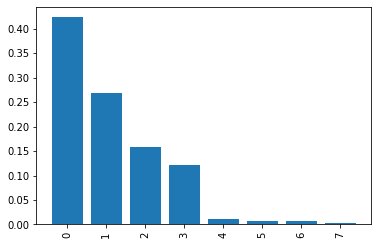

In [13]:
importances = rf_model.feature_importances_
sorted_index = np.argsort(importances)[::-1]
x_values = range(len(importances))

plt.bar(x_values, importances[sorted_index])
plt.xticks(rotation=90)
plt.show()